In [1]:
import math, matplotlib.pyplot as plt, torch

In [2]:
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create Data

Let's create some data with 4 clusters and 250 data points in each cluster

In [413]:
n_clusters = 6
n_samples = 250

Randomly generate 6 (x,y) coordinates that will act as the center of each cluster

In [414]:
centers = torch.rand(n_clusters, 2)*70-35

In [415]:
centers

tensor([[ 23.243,  11.558],
        [ 31.871,  14.926],
        [-32.264,  -7.003],
        [ 20.213, -21.441],
        [ 10.127,  -1.106],
        [-12.041,  -2.180]])

Randomly generate 250 points around each cluster's center using a normal distribution

In [416]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [417]:
def sample(mean): return MultivariateNormal(mean, torch.diag(tensor([9.,9.]))).sample((n_samples,))

In [418]:
m = centers[0]

In [419]:
sample(m)[:10]

tensor([[28.829, 11.157],
        [20.882, 12.562],
        [24.344, 10.567],
        [24.977, 11.950],
        [22.288, 13.601],
        [25.229, 11.351],
        [26.809, 14.041],
        [22.881, 14.463],
        [19.064, 14.002],
        [24.426,  9.893]])

In [420]:
slices = [sample(c) for c in centers]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [453]:
def plot_data(centers, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, center in enumerate(centers):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*center, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*center, markersize=5, marker="x", color='w', mew=2)

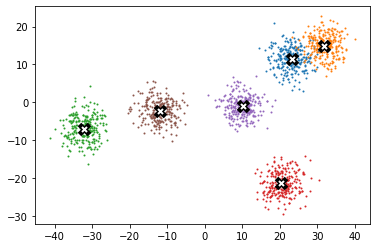

In [454]:
plot_data(centers, data, n_samples)

## DBSCAN Clustering 

In [455]:
 x = data[0]
X = data.clone()

In [456]:
x.shape, X.shape

(torch.Size([2]), torch.Size([1500, 2]))

We can calculate the L2 norm between the first point in our data and all the other points. Broadcasting is used here for the subtraction x-X.

In [457]:
dist = ((x-X)**2).sum(1).sqrt()
dist[:5]

tensor([0.000, 5.214, 4.958, 3.523, 5.660])

The same results can be achieved using Einstein summation

In [458]:
delta = x - X
dist = torch.einsum("ij, ij->i", delta, delta).sqrt()
dist[:5]

tensor([0.000, 5.214, 4.958, 3.523, 5.660])

Set number of nearby points required to 5 and the radius to 2

In [459]:
r = 2
n_required = 5

In [460]:
nearby = torch.nonzero(dist <= r)
nearby

tensor([[  0],
        [ 29],
        [ 33],
        [ 37],
        [ 44],
        [ 85],
        [ 91],
        [ 98],
        [154],
        [156],
        [162],
        [174],
        [177],
        [181],
        [194],
        [197],
        [224],
        [228],
        [245]])

In [461]:
X.shape

torch.Size([1500, 2])

In [462]:
def expand_cluster(nearby, cluster_label):
    i = 0
    while(i < nearby.shape[0]):
        x_index = nearby[i].item()
        if not visited[x_index]:
            visited[x_index] = True
            delta = X[x_index] - X
            dist = torch.einsum("ij, ij->i", delta, delta).sqrt()
            nearby_nearby = torch.nonzero(dist <= r)
            n_nearby_nearby = nearby.shape[0]
            if n_nearby_nearby >= n_required:
                nearby = torch.cat([nearby, nearby_nearby])
                
        #If nearby point not already in another group, add to current group
        if labels[x_index] == 0:
            labels[x_index] = cluster_label
        i += 1
                

In [463]:
labels = torch.zeros(n_samples * n_clusters,1)
cluster_label = 0
visited = torch.zeros(n_samples * n_clusters)
for i,x in enumerate(X):
    if visited[i]:
        continue
    visited[i] = True
    delta = x - X
    dist = torch.einsum("ij, ij->i", delta, delta).sqrt()
    nearby = torch.nonzero(dist <= r)
    n_nearby = nearby.shape[0]
    if n_nearby >= n_required:
        cluster_label += 1
        labels[i] = cluster_label
        expand_cluster(nearby, cluster_label)
    
X = torch.cat([X, labels], dim=1)

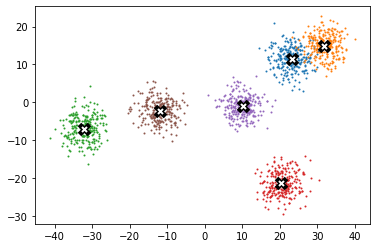

In [464]:
plot_data(centers, data, n_samples)

In [465]:
def plot_data(centers, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=1)
    for i, center in enumerate(centers):
        ax.plot(*center, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*center, markersize=5, marker="x", color='w', mew=2)

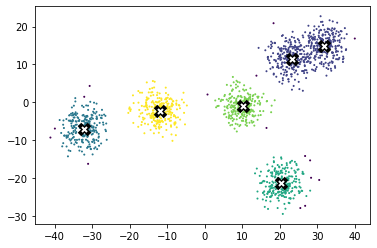

In [466]:
plot_data(centers, data, n_samples)

In [467]:
def dbscan(X, r, n_required):
    global labels, visited
    labels = torch.zeros(n_samples * n_clusters,1)
    cluster_label = 0
    visited = torch.zeros(n_samples * n_clusters,1)
    for i,x in enumerate(X):
        if visited[i]:
            continue
        visited[i] = True
        delta = x - X
        dist = torch.einsum("ij, ij->i", delta, delta).sqrt()
        nearby = torch.nonzero(dist <= r)
        n_nearby = nearby.shape[0]
        if n_nearby >= n_required:
            cluster_label += 1
            labels[i] = cluster_label
            expand_cluster(nearby, cluster_label)

    return labels

In [468]:
dbscan(X, r, n_required)

tensor([[1.],
        [1.],
        [1.],
        ...,
        [5.],
        [5.],
        [5.]])

In [470]:
%timeit labels = dbscan(X, r, n_required)

1.43 s ± 45.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## To-do: Optimise using GPU acceleration and do Animation

In [471]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML